In [ ]:
%pip install --upgrade --quiet praw pypdf langchain-core langgraph langchain_openai

## LangGraph Research Assistant

We'll build a research assistant that combines 3 themes: 

1) `Report Generation` -- [Reports provide greater value than question-answering tools used in many RAG systems](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). This is because reports offer more than just answers; they are tools for decision-making and resource allocation. Reports can save substantial costs by replacing the need for multiple employees or expensive processes.

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace conventional investment dilligence. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks (e.g., extracts all metrics, finds founder LinkedIns + extracts their background, writes to Notion).

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously inique about a topic (e.g., via an AI interview).

### Approach

As an example, we'll apply these to the [llama3.1 paper](https://ai.meta.com/blog/meta-llama-3-1/).

And we'll lay out our assistant like this: 

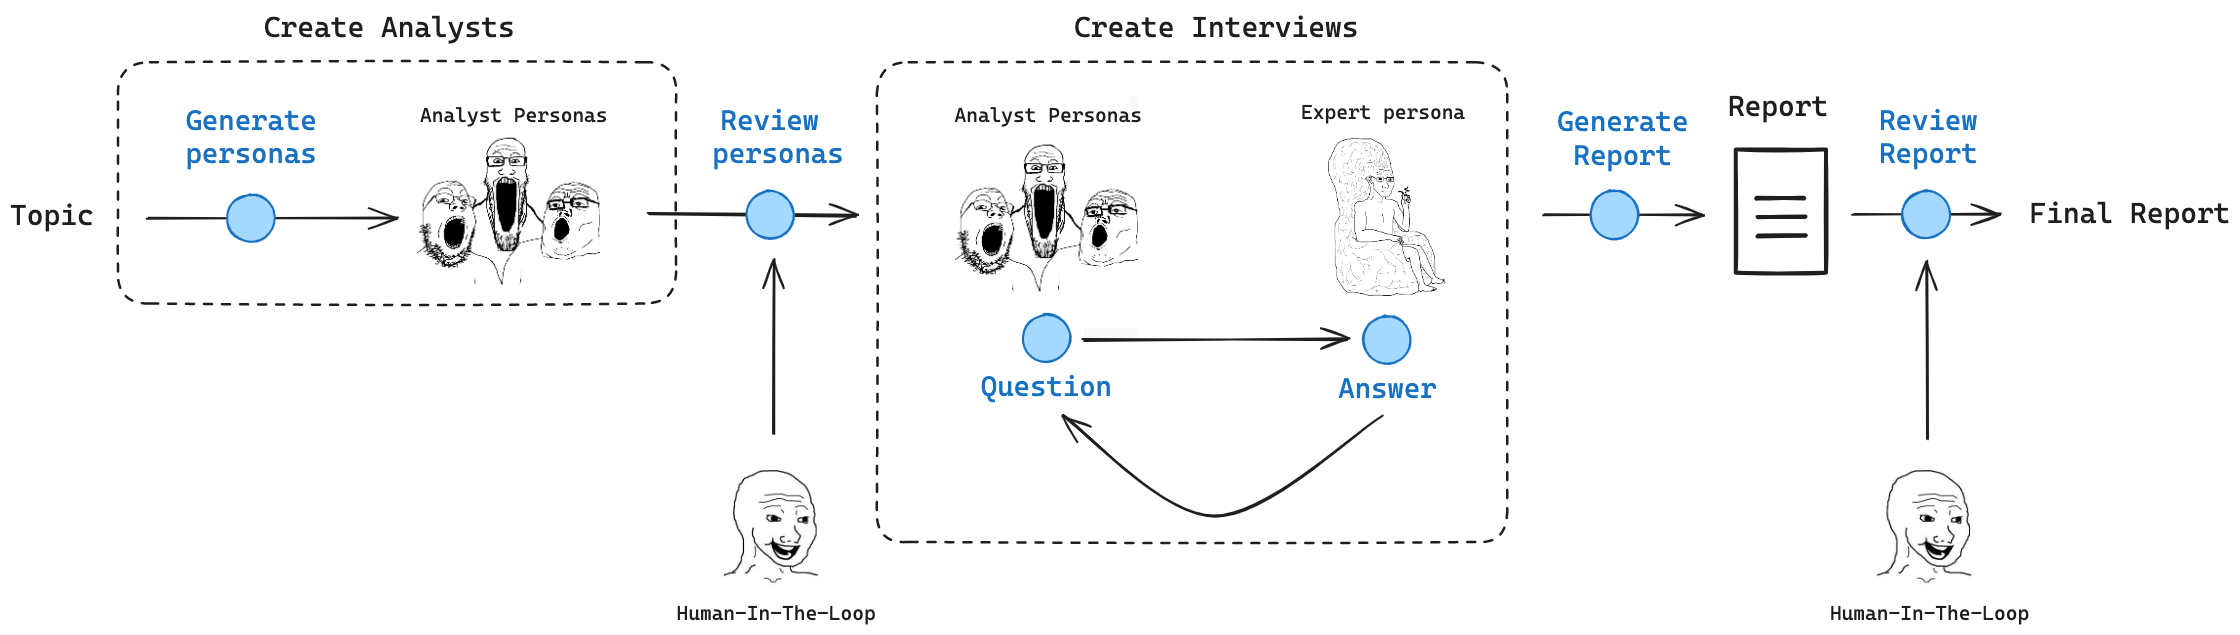

### Specify Topic and Content

First, select the topic of interest.

In [105]:
# Overall topic
topic = "Interesting topics and insights based upon Meta LLlama3.1 open source LLM work"

#### Context for creating the analysts

Next, we want to create our analysts. 

Here, we have some options:

1. Prompt an LLM with a few specific themes

2. Let an LLM choose the specifics based upon some provided context

We choose option 2, using either comments from localLLaMA reddit posts or from Zuck's blog post.

The idea here is that we use context to select more specific and interesting focus ares for our analysts. 

In [7]:
import praw

# URL of the Reddit post
url = 'https://www.reddit.com/r/LocalLLaMA/comments/1eabf4l/lets_discuss_llama31_paper_a_lot_of_details_on/'

# Replace the following values with your credentials
client_id = 'oXovK387OEwSmA'
client_secret = 'DgB2mfpr4y_JsbfIU2RdxujHGkU'
user_agent = 'Local Llama Loader'

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Fetch the submission
submission = reddit.submission(url=url)

# Load the comments
submission.comments.replace_more(limit=None)
comments = submission.comments.list()

# Concatenate comments into a single string
ANALYST_TOPIC_GENERATION_CONTEXT = "\n *** user commnent *** \n".join([comment.body for comment in comments])

We can also use Mark Zuckerberg's letter about llama3.1.

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
url = "https://about.fb.com/news/2024/07/open-source-ai-is-the-path-forward/"
ANALYST_TOPIC_GENERATION_CONTEXT = WebBaseLoader(url).load()

#### Context for your expert 

Next, we create our expert. 

Here we can use a few approaches:

1. `RAG:` Simply give the expert specific context (e.g., papers, source materials)

2. `Search:` Allow the expert to use web search.

Of course, we can also combine these.

Here, we simply use RAG as a starting point.
 
We can use the full llama3.1 paper (be careful, because this is higher token usage). 

In [9]:
# Full llama3.1 paper
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/Users/rlm/Desktop/llama3_1.pdf")
pages = loader.load_and_split()
EXPERT_CONTEXT_PAPER = "\n *** *** *** \n".join([page.page_content for page in pages])

If the context is large, as we have here, then an index can reduce the tokens used for generation.

In [66]:
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
all_pages_except_references=pages[:100]
vectorstore = SKLearnVectorStore.from_documents(all_pages_except_references,embedding=embeddings)
retriever = vectorstore.as_retriever(k=10)

We can also supplement this with a blog post.

In [70]:
from langchain_community.document_loaders import WebBaseLoader
url = "https://ai.meta.com/blog/meta-llama-3-1/"
EXPERT_CONTEXT_BLOG = WebBaseLoader(url).load()

### Create Interviews

#### State

Here, we outline the states that we will use for our graph.

`InterviewState` is the "inner state" in our final graph, which will be used for **each interview** between expert and analyst.

`ResearchGraphState` is the "outer state", which will collate results from all interviews, write sections, and write the final report.

In [124]:
import operator
from typing import List, Optional
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class InterviewState(TypedDict):
    topic: str
    messages: Annotated[List[AnyMessage], add_messages]
    analyst: Analyst
    editor_feedback: str
    interviews: list # This key is duplicated between "inner state" ...
    reports: list # This key is duplicated between "inner state" ...

class ResearchGraphState(TypedDict):
    analysts: List[Analyst]
    analyst_feedback: str 
    topic: str
    max_analysts: int
    interviews: Annotated[list, operator.add] # ... and "outer state"
    reports: Annotated[list, operator.add] # ... and "outer state"
    final_report: str
    editor_feedback: str 

#### LLM

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [6]:
from langchain_anthropic import ChatAnthropic
report_writer_llm = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0) 

#### Analysts

Create analysts based upon the `ANALYST_TOPIC_GENERATION_CONTEXT`.

In [24]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """
            You are tasked with creating a set of AI analyst personas. 
            
            Follow these instructions carefully:

            1. First, review the research topic:
            
            {topic}
            
            2. Carefully read and analyze the following documents related to the topic:
            
            {documents}
            
            3. Think carefully about the documents.
            
            4. Determine the most interesting themes and questions for research from the documents. 
            
            5. Assign AI analyst persona to each themes and / or question. 
            
            6. Choose the top {max_analysts} themes. The maximum number of personas you should create is:
            
            {max_analysts}
            
            6. If the user has specified any analyst personas they want included, incorporate them into your set of analysts. 
            
            Here is the user's optional input: {analyst_feedback}            
            """,
            
        ),
    ]
)

@as_runnable
def generate_analysts(state: ResearchGraphState):
    """ Node to generate analysts """

    # Get topic and max analysts from state
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    analyst_feedback = state.get("analyst_feedback", "")

    # Generate analysts
    gen_perspectives_chain = gen_perspectives_prompt | llm.with_structured_output(Perspectives)
    perspectives = gen_perspectives_chain.invoke({"documents": ANALYST_TOPIC_GENERATION_CONTEXT, 
                                                  "topic": topic, 
                                                  "analyst_feedback": analyst_feedback, 
                                                  "max_analysts": max_analysts})
    
    # Write the list of analysis to state
    return {"analysts": perspectives.analysts}

In [25]:
from langchain_core.messages import AIMessage, HumanMessage

# Test
initial_state = {"topic": topic, 
                 "analyst_feedback": "Make sure to include an analyst on the training strategy -- e.g., # of GPUs and network.",
                 "max_analysts": 6}

perspectives = generate_analysts.invoke(initial_state)

In [31]:
from pprint import pprint
for a in perspectives['analysts']:
    print("---")
    pprint(a.description)
    print("---")

---
('Dr. Rodriguez focuses on the training strategies employed in large-scale '
 'language models, including the number of GPUs used, network configurations, '
 'and optimization techniques. She is particularly interested in the '
 'efficiency and scalability of training processes.')
---
---
('Dr. Thompson specializes in tokenization methods and data quality '
 'assessment. He examines how the choice of tokens and the filtering of '
 'low-quality data impact the performance and accuracy of language models.')
---
---
("Dr. Singh's research focuses on the integration of multimodal capabilities "
 'in language models, including image, video, and speech recognition. She is '
 'interested in the challenges and innovations in creating models that can '
 'process and generate multiple types of data.')
---
---
('Dr. Chen investigates the effects of quantization on model performance, '
 'particularly focusing on novel evaluation methods and the impact of '
 'different quantization techniques o

### Ask Question

Prompt analyst to ask questions to the expert.

In [86]:
gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an experienced analyst tasked with interviewing an expert to learn about a specific topic. 

            Your goal is boil down to non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.
    
            Here is your topic of focus and set of goals: {persona}
            
            Begin by introducing yourself using a name that fits your persona, and then ask your question.

            Continue to ask questions to drill down and refine your understanding of the topic.
            
            When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

            Remember to stay in character throughout your response, reflecting the persona and goals provided to you.""",
        
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    gen_question_chain = gen_qn_prompt.partial(persona=analyst.persona) | llm   
    result = gen_question_chain.invoke({"messages": messages})
    
    # Write messages to state
    return {"messages": [result]}

In [50]:
# Test
messages = [HumanMessage(f"So you said you were researching {topic}?")]
i = 3 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}
question = generate_question.invoke(interview_state)
messages.extend(question['messages'])

### Create Expert

Prompt expert to answer question using `EXPERT_CONTEXT`.

You can be flexible with your approach here. 

If your raw context is small, then simply stuff `EXPERT_CONTEXT` directly.

Below, we use a combination of an index + retrieval from a long paper (90+ pages) as well as stuffing a shorter summary blog.

In [87]:
# Expert RAG prompt 
gen_expert_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert on the topic of {topic}.
            
            You are being interviewed by an analyst who focused on learning about a specific topic. 
            
            Your goal is to share non-obvious and specific insights related to your topic:

            1. Non-obvious: Insights that people will find surprising and therefore interesting.
            
            2. Specific: Insights that avoid generalities and include specific examples from the exprt.

            Here is the context you should use to inform your answers:
            {context}

            When answering questions, follow these guidelines:
            
            1. Use only the information provided in the context. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
                     
            2. If a question cannot be answered based on the given context, state that you don't have enough information to provide a complete answer.
            
            Remember, your ultimate goal is to help the analyst drill down to specific and non-obvious insights about the topic.""",
            
        ),
        
            MessagesPlaceholder(variable_name="messages", optional=True),
        ]
)

@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    messages = state["messages"]

    # Get context from the index of the paper
    retrieved_docs = retriever.invoke(messages[-1].content)

    # Add the technical blog post
    retrieved_docs.extend(EXPERT_CONTEXT_BLOG)

    # Format
    relevant_docs = "\n *** \n".join([f"Document # {i}\n{p.page_content}" for i, p in enumerate(retrieved_docs, start=1)])
    
    # Answer question
    answer_chain = gen_expert_prompt | llm
    answer = answer_chain.invoke({'messages': messages,
                                  'topic': topic,
                                  'context': relevant_docs})  
    
    # Name the message as coming from the expert
    # We use this later to count the number of times the expert has answered
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

In [ ]:
# Test
interview_state = {"analyst": perspectives["analysts"][i], 
                   "messages": messages}

answer = generate_answer.invoke(interview_state)
messages.extend(answer['messages'])

### Interview between expert and analyst

Combine the above into an interview graph.

Use `max_num_turns` to set the number of times you want the expert to answer.

If the expert is using a large context, as in the case here with llama3.1 paper, we can restrict this to only a single turn.

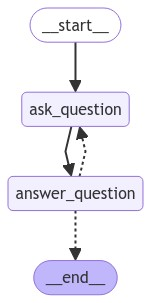

In [99]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Max turns
max_num_turns = 5

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return END

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return END
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages)

# Set up memory
memory = MemorySaver()

# Interview 
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [89]:
# Test
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
i = 3 # analyst to test 
interview_state = {"analyst": perspectives["analysts"][i], "messages": messages}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run
interview = await interview_graph.ainvoke(interview_state, thread)

We can get the state for the full interview.

In [ ]:
full_interview_state = interview_graph.get_state(thread).values["messages"]

And we can look at specific messages.

In [ ]:
full_interview_state[-1].content[0:250]

### Section writing

Write a section of the overall report based upon the interviews.

In [136]:
from langchain_core.messages import get_buffer_string
from langchain_core.output_parsers import StrOutputParser

report_gen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            """You are an expert analyst, writer, and editor. You will be given an interview.

            You will turn this interview into a report following these guidelines:

            1. Carefully analyze the content of the interview. 
            
            Your report will aim to share non-obvious and specific insights related to the interview.

            a. Non-obvious: Insights that people will find surprising and therefore interesting.
            
            b. Specific: Insights that avoid generalities and include specific examples from the exprt.
            
            2. Structured your report with two sub-sections:

            - Problem: What is the problem or challenge or theme to be solved. Why is it interesting or hard?
            
            - Solution: What specific and / or non-obvious approaches did they use to solve it.

            3. Avoid using excessive bullet points and highlighted text, but use it for specific areas where needed.
            
            4. Tell the story in clear narrative form.
            
            5. Use markdown formatting throughout the report. Use ## header for the start of your report.
               
            6. If editor feedback was provided, make sure to incorporate those points seamlessly into your report. """,
        
        ),
        ("human", """Here are the interviews conducted with experts on this topic:
                        <interviews>
                        {interviews}
                        </interviews>
            
                        Here is any editor feedback that should be incorporated into the report:
                        <editor_feedback>
                        {editor_feedback}
                        </editor_feedback>"""),
    ]
)

@as_runnable
def generate_report(state: InterviewState):
    """ Node to generate report """

    # State 
    topic = state["topic"]
    interviews = state["interviews"]
    editor_feedback = state.get("editor_feedback", [])

    # Full set of interviews
    formatted_str_interview = "\n\n".join([f"Interview # {i}\n{interview}" for i, interview in enumerate(interviews, start=1)])

    # Generate report
    report_gen_chain = report_gen_prompt | report_writer_llm | StrOutputParser()
    report = report_gen_chain.invoke({"interviews": formatted_str_interview, 
                                       "topic": topic,
                                       "editor_feedback": editor_feedback})
    
    return {"reports": [report]}

In [114]:
# Add in some editor feedback
editor_feedback = "Be sure to include context on what quantization is, and why it is interesting."

# Convert the messages in the interview into a string
initial_state= {"interviews": [get_buffer_string(interview['messages'])],
                "editor_feedback": editor_feedback,
                "topic": topic}

report = generate_report.invoke(initial_state)

In [115]:
from IPython.display import Markdown
Markdown(report['reports'][0].replace("\n#", "\n##"))

## Quantization: Unlocking Efficiency in Large Language Models

In the rapidly evolving field of artificial intelligence, researchers are constantly seeking ways to make large language models (LLMs) more efficient and accessible. One technique that has emerged as a game-changer is quantization. This process involves reducing the precision of numbers representing a model's parameters and activations, which may seem counterintuitive at first glance. After all, wouldn't reducing precision lead to a decrease in performance? Surprisingly, when done correctly, quantization can maintain model performance while dramatically improving efficiency.

#### Problem: Balancing Performance and Efficiency in LLMs

Large language models like Meta's Llama 3.1 have shown remarkable capabilities in natural language processing tasks. However, these models come with significant computational and memory requirements, making them challenging to deploy and scale in real-world applications. The key challenge lies in finding ways to reduce these resource demands without compromising the model's performance.

This is where quantization becomes interesting. It addresses a fundamental tension in AI development: how to make models more powerful and capable while simultaneously making them more efficient and deployable. The difficulty lies in reducing the precision of the model's parameters without losing the nuanced understanding and generation capabilities that make these models so powerful.

#### Solution: Advanced Quantization Techniques

Meta's work on Llama 3.1 showcases innovative approaches to quantization that effectively balance performance and efficiency:

1. **Row-wise Quantization**: Instead of applying a single scaling factor to the entire tensor, this technique computes scaling factors for each row of the parameter and activation matrices. This granular approach allows for more accurate representation of the original values, minimizing quantization error and preserving the model's performance.

2. **Dynamic Scaling Factors**: This method adapts the range of representable values in real-time during the model's operation. By upper bounding these factors to 1200, Meta prevents issues like underflows and decoding errors that could arise from excessively large scaling factors.

The impact of these techniques is significant:

- **Memory Footprint Reduction**: By lowering precision from 16-bit floating point (BF16) to 8-bit floating point (FP8), the memory required to store model parameters is substantially reduced. This is crucial for massive models like Llama 3.1 405B.

- **Throughput Improvements**: The use of FP8 quantization has led to throughput improvements of up to 50% during the pre-fill stage of inference. This means the model can process more data in less time, a critical factor for real-time applications.

- **Energy Efficiency**: Lower precision computations consume less power, an important consideration for large-scale deployments where energy costs can be substantial.

Perhaps most surprisingly, these efficiency gains come with minimal impact on model performance. The reward score distribution for Llama 3.1 using FP8 inference is almost identical to that using BF16, indicating that the model's responses remain consistent and reliable even after quantization.

A real-world application of these techniques can be seen in Meta's deployment of multilingual conversational agents. By applying row-wise quantization and dynamic scaling factors, Meta was able to handle diverse linguistic patterns more effectively, manage wide ranges of activation values, and support complex interactions across multiple languages. This resulted in high-quality, real-time multilingual support on platforms like WhatsApp and Messenger, all while operating efficiently on Meta's infrastructure.

The success of these quantization techniques in maintaining performance while significantly improving efficiency opens up new possibilities for the deployment of large language models. As these models continue to grow in size and capability, techniques like those employed by Meta will be crucial in making advanced AI more accessible and practical for a wide range of applications.

## Full Analyst

Now, we combine and parallelize these steps:

* `interview_builder` is a sub-graph that conducts the interview
* We write the interview to our "inner state" (`InterviewState`) key, `interviews`
* Key point: this is propogated our to the "outer state" key, `interviews`
* Our "outer state" key has a reducer that appends the results from each interview to the key, `interviews`

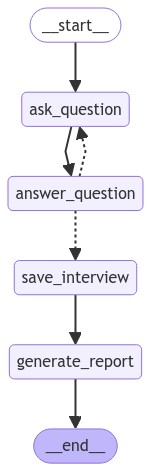

In [137]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews
    return {"interviews": [interview]}

# Conditional edge
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is perform after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return "save_interview"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("generate_report", generate_report) # Include this in the interview graph

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,["ask_question","save_interview"])
interview_builder.add_edge("save_interview", "generate_report")
interview_builder.add_edge("generate_report", END)

sub_graph = interview_builder.compile(checkpointer=memory)
display(Image(sub_graph.get_graph(xray=1).draw_mermaid_png()))

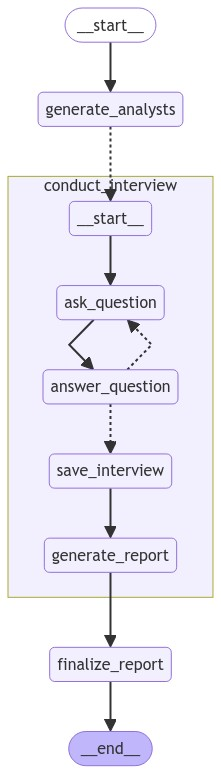

In [143]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ Edge to run the interview sub-graph using Send """    
    return [Send("conduct_interview", {"analyst": analyst,
                                       "messages": [HumanMessage(
                                           content=f"So you said you were writing an article on {topic}?"
                                       )
                                                   ]}) for analyst in state["analysts"]]
    
def refine_report(state: ResearchGraphState):
    """ Optionally, refine the report. Not currently used!
        We used this when the generate_report was a final step
        But, we found that the LLM did not always have the capacity to generate the full report
        So, instead we generate each section in the map step with the interview
    """
    
    editor_feedback = state.get("editor_feedback", None)
    if not editor_feedback:
       return END
    return "generate_report"

def finalize_report(state: ResearchGraphState):
    """ Optionally, refine the report 
        We used this when the generate_report was a final step
        But, we found that the LLM did not always have the capacity to generate the full report
        So, instead we generate each section in the map step with the interview
    """
    
     # Full set of interviews
    sections = state["reports"]
    formatted_str_sections = "\n\n".join([f"{section}" for i, section in enumerate(sections, start=1)])

    final_report_gen_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                
                """You are an expert analyst, writer, and editor. You will be given a full report.
    
                Write a crisp and compelling introduction for the report.

                Include no pre-amble.
    
                Use markdown formatting. Use # header for the start along with a title for the overall report.""",
            
            ),
            ("human", """Here are the interviews conducted with experts on this topic:
                            <sections>
                            {sections}
                            </sections>"""),
        ]
    )

    # Generate report
    final_report_gen_chain = final_report_gen_prompt | report_writer_llm | StrOutputParser()
    report_intro = final_report_gen_chain.invoke({"sections": formatted_str_sections})
    return {"final_report": report_intro + "\n\n" + formatted_str_sections}
    
builder = StateGraph(ResearchGraphState)
builder.add_node("generate_analysts", generate_analysts)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "generate_analysts")
builder.add_conditional_edges("generate_analysts", initiate_all_interviews, ["conduct_interview"])
builder.add_edge("conduct_interview", "finalize_report")
builder.add_edge("finalize_report", END)
# builder.add_conditional_edges("generate_report", refine_report, ["generate_report", END])

graph = builder.compile(checkpointer=memory,
                        interrupt_before=["generate_analysts"],)
                        # interrupt_after=["generate_report"])

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Thread
thread = {"configurable": {"thread_id": "18"}}

# Test
initial_state = {"topic": topic, 
                 "max_analysts": 5}

# Run the graph until the first interruption
for event in graph.stream(initial_state, thread, stream_mode="values"):
    print(event)

# "E.g., I am interested in the training strategy -- e.g., # of GPUs and network.
user_preference_analyst = input("Do you have any specific analyst personas that you want to include?")

# Update state
updated_state = {"analyst_feedback": user_preference_analyst}
graph.update_state(thread, updated_state)

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

In [141]:
from IPython.display import Markdown
Markdown(graph.get_state(thread).values["final_report"].replace("\n#", "\n##"))

Here's a crisp and compelling introduction for the report:

## Revolutionizing AI: Meta's LLaMA 3.1 Pushes the Boundaries of Language Models

In the rapidly evolving landscape of artificial intelligence, Meta's LLaMA 3.1 emerges as a groundbreaking advancement in large language model technology. This comprehensive report delves into the innovative approaches and solutions that have propelled LLaMA 3.1 to the forefront of AI research and development.

From pioneering data quality techniques to revolutionary multimodal integration, LLaMA 3.1 represents a significant leap forward in the quest for more capable, efficient, and versatile AI systems. This analysis explores the cutting-edge methods employed by Meta's team, including advanced quantization strategies, sophisticated distributed training solutions, and novel approaches to balancing model complexity with practical implementation.

As we unpack the intricacies of LLaMA 3.1, we'll discover how Meta's focus on simplicity, scale, and data quality has challenged conventional wisdom in AI development, potentially reshaping the future of language models and their applications across various industries.## Enhancing Data Quality for Meta's LLaMA 3.1: Advanced Techniques in Large Language Model Training

Large language models (LLMs) have revolutionized natural language processing, but their performance heavily depends on the quality of training data. Meta's LLaMA 3.1 employs cutting-edge techniques to ensure superior data quality, addressing a critical challenge in AI development.

#### Problem: The Data Quality Conundrum

Training LLMs on vast amounts of data poses a significant challenge: how to filter out low-quality, redundant, or irrelevant information without losing valuable content. Traditional methods often fall short in handling the scale and complexity of data required for state-of-the-art models like LLaMA 3.1.

The problem is multifaceted:
1. Identifying and removing repetitive content that appears unique at first glance
2. Efficiently processing and evaluating enormous datasets
3. Maintaining a balance between data diversity and quality
4. Ensuring the model learns from the most relevant and informative examples

#### Solution: Meta's Innovative Approach to Data Refinement

Meta has developed a suite of sophisticated techniques to tackle these challenges, significantly improving the quality of LLaMA 3.1's training data:

1. **Advanced Heuristic Filtering**

Meta employs the "Duplicated n-gram Coverage Ratio" method, a non-obvious approach that goes beyond traditional line-deduplication. This technique identifies and removes repetitive content patterns, even when they appear in slightly different forms. For instance, it can filter out repetitive log entries or error messages that might have unique timestamps but contain the same core information.

This method is particularly effective in cleaning datasets containing software logs or repetitive web content, ensuring that LLaMA 3.1 isn't trained on redundant information that could skew its learning process.

2. **Model-Based Quality Filtering**

Meta utilizes a two-tiered approach for efficient quality assessment:

- Fast classifiers like FastText for initial screening
- More sophisticated Roberta-based classifiers for in-depth evaluation

A standout technique is the use of DistilRoberta to generate quality scores for each document. This allows for granular selection of high-quality content, significantly improving the overall dataset quality.

For example, when processing a mix of technical articles and forum posts about programming, DistilRoberta might assign a high score (e.g., 0.92) to a well-written technical article and a low score (e.g., 0.45) to a fragmented forum post. By setting an appropriate threshold, only the highest quality content is retained for training.

3. **PagedAttention for Efficient Rejection Sampling**

One of the most innovative approaches in LLaMA 3.1's data preparation is the use of PagedAttention for rejection sampling. This technique dynamically allocates key-value cache pages, optimizing memory usage and improving throughput by over 200% during the sampling process.

PagedAttention allows the system to efficiently generate and evaluate multiple responses for a given prompt, ensuring only the highest quality outputs are selected for training. This is crucial for complex tasks like reasoning questions, where the model needs to learn from the best possible examples.

The efficiency gains from PagedAttention are not just about speed; they enable more thorough quality checks and allow for processing larger volumes of data, ultimately contributing to a more robust and capable model.

4. **Domain-Specific Pipelines and Semantic Deduplication**

Meta has developed specialized pipelines for extracting high-quality content related to code and mathematical reasoning. These pipelines use DistilledRoberta models trained on web data annotated by LLaMA 2, ensuring highly relevant and quality content extraction.

Furthermore, the use of semantic deduplication through clustering and cosine similarity checks ensures minimal redundancy in the dataset. This approach preserves content diversity while eliminating near-duplicate entries, a balance that is crucial for comprehensive language understanding.

By implementing these advanced techniques, Meta has significantly enhanced the quality of data used to train LLaMA 3.1. This refined approach to data preparation sets a new standard in LLM development, potentially leading to more accurate, reliable, and versatile language models. The innovations in data quality management not only improve LLaMA 3.1's performance but also pave the way for future advancements in AI and natural language processing.

### Llama 3.1: Simplicity, Scale, and Data Quality Triumph Over Architectural Complexity

In the rapidly evolving field of artificial intelligence, Meta's Llama 3.1 stands out as a testament to the power of simplicity and data-driven approaches. While many AI researchers have been exploring complex architectural innovations like Mixture of Experts (MoE) and InstructGPT, the team behind Llama 3.1 made the surprising decision to stick with a more traditional, dense Transformer architecture. This choice, coupled with a laser focus on data quality and scale, has yielded impressive results that challenge conventional wisdom in the AI community.

#### Problem: Balancing Complexity, Performance, and Practicality in Large Language Models

The development of large language models (LLMs) faces a constant tension between architectural complexity, performance gains, and practical implementation. As models grow larger and more sophisticated, researchers often turn to intricate architectural innovations to squeeze out additional performance. However, these complex designs can introduce significant challenges in training stability, inference efficiency, and real-world deployment.

The Llama 3.1 team faced the daunting task of creating a state-of-the-art open-source LLM that could compete with proprietary models while remaining practical for widespread use. They needed to balance the allure of cutting-edge architectures with the realities of training at massive scale and ensuring reliable performance across a wide range of tasks.

#### Solution: Embracing Simplicity, Scaling Data, and Innovative Training Techniques

Rather than following the trend towards more complex architectures, the Llama 3.1 team made several non-obvious choices that contributed to the model's success:

1. **Prioritizing Data Quality and Scale**: Instead of adopting architectural innovations like MoE or InstructGPT, the team focused on dramatically improving the quality and scale of their training data. They increased the pre-training dataset from 1.8 trillion tokens in Llama 2 to a staggering 15 trillion multilingual tokens for Llama 3.1. This massive increase in high-quality, diverse data proved to be a key driver of the model's performance improvements.

2. **Sticking with a Dense Transformer Architecture**: The team found that the benefits of more complex architectures did not outweigh the added complications in training and deployment. By opting for a standard, dense Transformer model with minor adaptations like grouped query attention (GQA), they ensured training stability and efficient inference while still achieving competitive performance.

3. **Innovative Data Assessment Techniques**: The team employed a novel technique called "annealing" to quickly assess the value of small, domain-specific datasets. By adjusting the learning rate of a partially trained model on these high-quality datasets, they could efficiently determine their worth without extensive retraining experiments.

4. **Iterative Post-Training Refinement**: Instead of relying on InstructGPT-like innovations, the team developed an iterative post-training procedure involving supervised fine-tuning, rejection sampling, and Direct Preference Optimization. This approach allowed them to incrementally refine the model's capabilities and generate high-quality synthetic data for further improvements.

5. **Organizational Strategies for Unbiased Development**: The team implemented surprising organizational decisions to ensure the model's integrity. For example, they used separate teams for data procurement and processing to avoid contamination with common benchmarks. Human evaluations were conducted by a small group of researchers not involved in model development, ensuring unbiased assessments.

These non-obvious approaches allowed the Llama 3.1 team to create a highly competitive open-source model that excels in general knowledge, multilingual translation, and various other capabilities. By prioritizing simplicity, data quality, and innovative training techniques over architectural complexity, they demonstrated that sometimes the most effective solutions lie in refining and scaling proven approaches rather than constantly chasing the latest architectural trends.

The success of Llama 3.1 challenges the AI community to reconsider the balance between architectural innovation and practical implementation, highlighting the immense potential of well-executed, data-driven approaches in advancing the field of large language models.

### Pushing the Boundaries of AI Efficiency: FP8 Quantization in Meta's Llama 3.1

#### Problem: Balancing Model Performance and Computational Efficiency

As large language models (LLMs) continue to grow in size and complexity, researchers face a significant challenge: how to maintain or improve model performance while reducing computational demands. This balancing act is crucial for making advanced AI more accessible and practical for real-world applications. The problem is particularly acute when it comes to model inference, where speed and efficiency are paramount for user-facing applications.

Meta's Llama 3.1 tackles this challenge head-on with its innovative approach to FP8 quantization. But why is quantization so important, and what makes FP8 quantization in Llama 3.1 stand out?

Quantization involves reducing the precision of numerical representations in a model, typically from higher-precision formats like 32-bit or 16-bit floating-point numbers to lower-precision formats. This reduction in precision can significantly decrease memory usage and computational requirements, potentially leading to faster inference times and lower power consumption. However, the trade-off is that reducing precision can also lead to a loss in model accuracy if not done carefully.

#### Solution: Innovative FP8 Quantization Techniques in Llama 3.1

Meta's approach to FP8 quantization in Llama 3.1 introduces several innovative techniques that address the challenges of maintaining model accuracy while reaping the benefits of reduced precision:

1. Row-wise Quantization:
   Instead of applying quantization across entire tensors, Llama 3.1 employs row-wise quantization. This approach allows for more granular control over the quantization process, computing scaling factors across rows for parameter and activation matrices. The result is a better preservation of data variance and distribution within each row, which is crucial for maintaining model accuracy.

2. Upper Bounding of Dynamic Scaling Factors:
   To mitigate the risk of corrupted responses due to extreme values, Llama 3.1 introduces an upper bound on dynamic scaling factors. Specifically, these factors are capped at 1200. This seemingly simple technique is vital for preventing underflows and errors in decoding, particularly for high-perplexity tokens like dates that can lead to large activation values.

3. Negligible Impact on Model Responses:
   Perhaps one of the most surprising outcomes of Llama 3.1's FP8 quantization approach is its minimal impact on model responses. Despite the significant reduction in precision, the model maintains performance levels comparable to higher-precision versions. This achievement is counterintuitive, as one might expect a noticeable drop in performance with such a drastic reduction in numerical precision.

4. Substantial Efficiency Gains:
   The FP8 quantization in Llama 3.1 leads to remarkable improvements in efficiency. Throughput improvements of up to 50% during the pre-fill stage have been observed, along with a significantly better throughput-latency trade-off during decoding compared to two-machine BF16 inference.

These techniques have enabled real-world improvements in various applications:

- Enhanced Speech Synthesis: The Llama 3.1 8B model has shown significant improvements in speech synthesis tasks, outperforming both streaming and non-streaming phone-only baselines in prosody modeling evaluation.

- Advanced Multilingual Conversational Agents: The upgraded 8B and 70B models support complex use cases like multilingual conversational agents, leveraging their extended context length of 128K and state-of-the-art tool use capabilities.

- Large-Scale Synthetic Data Generation: The efficiency gains from FP8 quantization have made it feasible to generate large volumes of high-quality synthetic data, crucial for improving and training smaller models and for model distillation.

Looking ahead, the future of quantization techniques in LLMs is promising. Potential advancements include:

- Adaptive quantization techniques that dynamically adjust precision based on data complexity.
- Hybrid quantization approaches combining different methods within the same model.
- Integration of quantization-aware training to mitigate accuracy loss.
- Development of more sophisticated algorithms for determining dynamic scaling factors.
- Collaboration with hardware manufacturers to create specialized GPUs and TPUs optimized for low-precision formats like FP8.

In conclusion, Meta's innovative approach to FP8 quantization in Llama 3.1 represents a significant step forward in the quest to balance model performance with computational efficiency. By addressing the challenges of quantization with novel techniques, Meta has not only

### Pushing the Boundaries of AI: Meta's Llama 3.1 and the Multimodal Revolution

#### Problem: The Challenge of True Multimodal AI

The development of large language models (LLMs) has been a game-changer in the field of artificial intelligence. However, the real world is not confined to text alone. It's a rich tapestry of sights, sounds, and written information. The challenge lies in creating AI systems that can seamlessly integrate and understand multiple modalities - text, speech, and images - in a way that mimics human-like comprehension and interaction.

Meta's Llama 3.1 represents a significant leap forward in addressing this complex challenge. The goal is not just to process different types of data independently, but to create a unified system that can understand and generate content across various modalities, opening up new possibilities for AI applications in real-world scenarios.

#### Solution: Innovative Approaches in Llama 3.1's Multimodal Integration

Meta's approach to solving the multimodal challenge with Llama 3.1 involves several innovative techniques:

1. **Speech Encoder Stabilization**: The team employed a unique method of using 16 different codebooks during the quantization of mel-spectrogram features. This approach, combined with a multi-softmax loss applied only on masked frames, was crucial in stabilizing the pre-training of the speech encoder. This technique allowed for effective processing of complex speech data, a fundamental component of multimodal interaction.

2. **Real-Time Speech Synthesis**: To enable low-latency, high-quality speech output, Llama 3.1 incorporates a prosody model with a lookahead mechanism. This innovative approach considers a fixed number of future phones and a variable number of future tokens, ensuring smooth and natural-sounding speech generation in real-time applications.

3. **Adapter Training for Multimodal Integration**: The integration of pre-trained image and speech encoders into the language model was achieved through a series of cross-attention layers. Interestingly, during this adapter training, the core language model parameters were kept frozen. This decision preserved the model's fundamental language capabilities while enabling it to process multimodal inputs effectively.

4. **Synthetic Data Generation**: A breakthrough in improving the model's performance across various capabilities was the use of synthetic data generation for supervised fine-tuning (SFT). This iterative process involved multiple rounds of generating and filtering synthetic data, crucial for enhancing the model's abilities in areas like multilingual translation and tool use.

5. **Efficient Quantization**: To make the massive 405B parameter model more accessible and cost-effective, Llama 3.1 was quantized from 16-bit (BF16) to 8-bit (FP8) numerics. This quantization significantly reduced compute requirements, allowing the model to run within a single server node and making it more feasible for real-world applications.

These approaches have led to practical applications in various fields. For instance, in document understanding and processing, Llama 3.1 integrates OCR capabilities to extract and understand text from images, enabling efficient digitization of printed documents like legal contracts or medical records. The model's ability to interleave speech and text inputs has found applications in customer service, where users can interact using both modalities simultaneously.

However, the deployment of such advanced multimodal systems is not without challenges. Issues like maintaining low latency in real-time applications, ensuring data quality and mitigating biases, achieving deep contextual understanding across modalities, and addressing scalability and resource requirements have emerged. Meta is actively working on these challenges through collaborative efforts, continuous improvement, and the development of safety tools like Llama Guard 3 and Prompt Guard.

The journey of Llama 3.1 represents a significant step towards creating AI systems that can truly understand and interact with the world in a more human-like manner. As these multimodal capabilities continue to evolve, we can expect to see increasingly sophisticated and practical applications of AI across various industries, potentially revolutionizing how we interact with technology in our daily lives.

### Scaling the Summit: Meta's Innovative Solutions for Training Llama 3.1

#### Problem: The Hidden Complexities of Large-Scale Model Training

Training massive language models like Meta's Llama 3.1 is far more complex than simply throwing more computing power at the problem. While the sheer scale of computation required is daunting, it's the non-obvious challenges that truly test the limits of distributed training infrastructure. These hurdles go beyond raw processing power, touching on intricate issues of network topology, data management, and system reliability.

One of the most pressing challenges is the inefficiency of traditional network architectures when dealing with the enormous data flows required for model training. Conventional load-balancing techniques struggle to handle the intense, coordinated communication between thousands of GPUs. Additionally, the process of periodically saving the model's state (checkpointing) creates sudden, massive bursts of data that can overwhelm storage systems. 

Perhaps most critically, the synchronous nature of large-scale training makes the entire process surprisingly fragile. A single GPU failure can force a restart of the entire training job, potentially losing days of progress. These issues are compounded by the difficulties in maintaining numerical stability across different parallelism setups and the inefficiencies in collective communication over high-latency networks.

#### Solution: Meta's Multifaceted Approach to Distributed Training

To tackle these challenges, Meta has developed a suite of innovative solutions that push the boundaries of distributed computing:

1. **Advanced Network Topology and Load Balancing**

Meta employs a sophisticated three-layer Clos network topology with a 1:7 oversubscription ratio at the aggregation layer. To overcome the limitations of traditional load-balancing methods, they've implemented a novel approach: creating 16 network flows between each pair of GPUs instead of just one. This seemingly counterintuitive strategy actually reduces traffic per flow and provides more paths for data transfer, resulting in more efficient communication.

2. **Tectonic: A File System Built for Bursts**

To handle the intense, bursty nature of checkpoint writes, Meta developed the Tectonic distributed file system. This powerhouse can sustain a throughput of 2 TB/s and peak at an astounding 7 TB/s. Tectonic's ability to absorb these massive data bursts allows for more frequent checkpointing, minimizing the amount of work lost in case of failures.

3. **Fault Tolerance Through Speed and Diagnostics**

Despite facing 466 job interruptions during a 54-day training period (78% due to hardware issues), Meta achieved over 90% effective training time. This remarkable feat was accomplished by drastically reducing job startup and checkpointing time, coupled with the development of sophisticated diagnostic tools for rapid problem identification and resolution.

4. **NCCLX: Reinventing Collective Communication**

Meta's fork of Nvidia's NCCL library, called NCCLX, introduces critical optimizations for high-latency networks. It prioritizes small control messages to prevent bottlenecks, reduces memory-copy operations, and implements asynchronous point-to-point communication. These enhancements significantly improve the efficiency of collective operations, especially in the outermost parallelism dimensions that communicate across multiple network hops.

5. **Numerical Stability Through Precision Management**

To maintain training stability across different parallelism configurations, Meta employs FP32 gradient accumulation during backward computation and reduces-scatter gradients in FP32 across data parallel workers. This careful management of numerical precision helps ensure consistent convergence, regardless of the specific parallelism setup used.

By addressing these non-obvious challenges with innovative, tailored solutions, Meta has created a training infrastructure capable of scaling to the immense demands of models like Llama 3.1. Their multifaceted approach not only pushes the boundaries of what's possible in large-scale distributed training but also provides valuable insights for the broader AI research community tackling similar challenges.